# ESDIRK methods in Extensisq

Extensisq implements two methods of Hosea and Shampine and 3 methods of Kennedy and Carpenter. Implicit methods are useful to integrate stiff ODE's. Explicit method fail or struggle with stiff ODEs.

Implicit methods have a few extra options that are demonstrated in this notebook.

## Linear problem of Hosea: Stiffness, Jacobian definition and linearity
Let's start with the linear problem from the paper of Hosea.
$$\boldsymbol{y}^\prime = \begin{bmatrix} -500 & 0 \\ 0 & -1 \end{bmatrix}\boldsymbol{y} + \begin{Bmatrix} 500 \cos (t) - \sin (t) \\ \sin (t) + \cos (t) \end{Bmatrix}$$

Which has solution $y_1 = \cos(t), y_2 = \sin(t)$ with appropriate initial conditions.

In [18]:
from scipy.integrate import solve_ivp
import numpy as np
from extensisq import TRX2, Me4

y0 = np.array([1., 0.])
t_span = (0., 12.)

def fun(t, y):
    dy0 = -500*y[0] + 500*np.cos(t) - np.sin(t)
    dy1 = -y[1] + np.sin(t) + np.cos(t)
    return np.asarray([dy0, dy1])

print("solving with explicit method...")
sole = solve_ivp(fun, t_span, y0, method=Me4)
print(f"message case 1: {sole.message}")
print(f"Nr of function evaluations: {sole.nfev}")

print("\nsolving with implicit method (numerical Jacobian)...")
soln = solve_ivp(fun, t_span, y0, method=TRX2)
print(f"message case 1: {soln.message}")
print(f"Nr of function evaluations: {soln.nfev}")
print(f"Nr of Jacobian evaluations: {soln.njev}")
print(f"Nr of LU decompositions: {soln.nlu}")

solving with explicit method...
message case 1: The solver successfully reached the end of the integration interval.
Nr of function evaluations: 8491

solving with implicit method (numerical Jacobian)...
message case 1: The solver successfully reached the end of the integration interval.
Nr of function evaluations: 209
Nr of Jacobian evaluations: 8
Nr of LU decompositions: 35


This problem has some mild stiffness and can still be integrated with an explicit method. However, as the test above shows, the explicit method needs ~90 times as many function evaluations making it very inefficient. On the other hand, implicit methods need to solve a system of equations (iteratively if the ODE is non-linear). This has costs in each step due to the assembly of the jacobian and the LU decomposition of the implicit system matrix.

In the example above, the implicit method was called without the `jac` argument. This makes the method use an finite difference estimate of the jacobian. This is typically a costly procedure that needs many function evaluations that are not counted in `solution.nfev`. Although the method works fine here and it is convenient for the user not to bother with the Jacobian, using numerical Jacobians is not recommended in general. Robustness and efficiency may suffer for many problems.

The Jacobian of the ODE, is defined as:
$$\frac{\partial \boldsymbol{f}(t, \boldsymbol{y})}{\partial \boldsymbol{y}} = \begin{bmatrix}
\frac{\partial f_1}{\partial y_1} & \cdots & \frac{\partial f_1}{\partial y_n} \\ 
\vdots & \ddots & \vdots \\
\frac{\partial f_n}{\partial y_1} & \cdots & \frac{\partial f_n}{\partial y_n} \end{bmatrix}.$$
For the current linear problem it is simply the matrix that is also used in the problem definition above. It can passed as a dense or sparse matrix or as a function. **For linear problems it is recommended to pass the Jacobian as a matrix.**

In [19]:
jac = np.array([[-500, 0], [0, -1.]])

print("solving with implicit method (matrix Jacobian)...")
solm = solve_ivp(fun, t_span, y0, jac=jac, method=TRX2)
print(f"message case 1: {solm.message}")
print(f"Nr of function evaluations: {solm.nfev}")
print(f"Nr of Jacobian evaluations: {solm.njev}")
print(f"Nr of LU decompositions: {solm.nlu}")

solving with implicit method (matrix Jacobian)...
message case 1: The solver successfully reached the end of the integration interval.
Nr of function evaluations: 98
Nr of Jacobian evaluations: 0
Nr of LU decompositions: 45


The number of function evaluations roughly halved, because only one iteration is needed to solve a linear stage. On the other hand, the number of LU decompositions is increased. A new decomposition is calculated each time the step size changes.

Another option is to pass the Jacobian with a function.

In [20]:
def jac_fun(t, y, jac=jac):
    return jac

print("solving with implicit method (callable Jacobian)...")
solf = solve_ivp(fun, t_span, y0, jac=jac_fun, method=TRX2)
print(f"message case 1: {solf.message}")
print(f"Nr of function evaluations: {solf.nfev}")
print(f"Nr of Jacobian evaluations: {solf.njev}")
print(f"Nr of LU decompositions: {solf.nlu}")

solving with implicit method (callable Jacobian)...
message case 1: The solver successfully reached the end of the integration interval.
Nr of function evaluations: 264
Nr of Jacobian evaluations: 20
Nr of LU decompositions: 30


As you can see, the number of function evaluations increases substantially, because at least 2 iteration are needed to confirm a converged stage solution. The number of LU decompositions is reduced again. Moreover, the jacobian is evaluated quite a few times. Clearly, the heuristics of the method don't detect that the system is linear. Otherwise, the Jacobian function would be called only once. These heuristics may be suboptimal, but erring on the conservative side may not be bad overall. (Failed steps can be costly too.)

The main implication is to **always use a function for `jac` if the ODE is non-linear**, even if you want to use a constant approximate Jacobian! This behavior is different from the implicit methods in scipy.

You can force a Jacobian update each step for non-linear problems with argument `jac_each_step` but the minimum number of iterations per stage remains 2. 

### comparing the errors

It is interesting to compare the errors. A plot is made to view the errors in one glance:

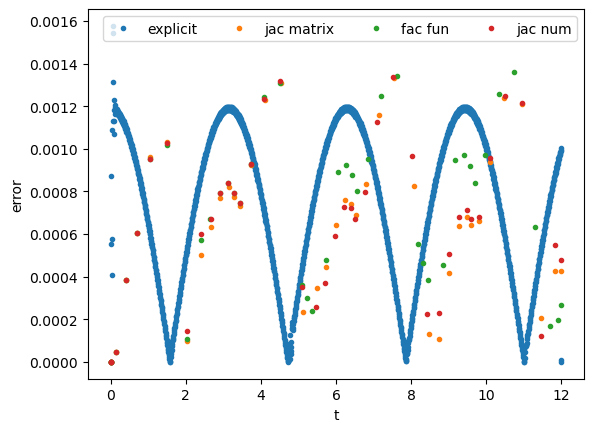

In [21]:
import matplotlib.pyplot as plt

def ref(t):
    return np.stack([np.cos(t), np.sin(t)])

def err_norm (t, y):
    err = y - ref(t)
    return np.sum(err**2, axis=0)**0.5

for sol, label in zip([sole, solm, solf, soln], 
                      ['explicit', 'jac matrix', 'fac fun', 'jac num']):
    plt.plot(sol.t, err_norm(sol.t, sol.y), '.', label=label)
plt.legend(ncol=4)
plt.xlabel('t')
plt.ylabel('error')
plt.show()

These errors are with respect to the actual solution, not the estimated errors from the embedded methods. The errors in the plot are rather similar. So, even though the explicit method uses many small steps, this does not lead to a reduced error.



## Singular perturbation problem: mass matrix and index 1 DAEs

The second problem in this notebook is Kaps' problem as given in the paper of Kennedy and Carpenter. This is a singular perturbation problem (SPP) that becomes a differential algebraic equation (DAE), as opposed to ODE, in the limit. My understanding of SPPs and DAE's is limited; please don't hesitate to contact me with suggestions to improve this notebook.

The paper defines Kaps' problem as:
$$ \begin{Bmatrix} y_1^\prime \\ y_2^\prime \end{Bmatrix} = \begin{Bmatrix} -(\epsilon^{-1} + 2) y_1 + \epsilon^{-1}y_2^2 \\ y_1 - y_2 - y_2^2 \end{Bmatrix} $$
with exact solution $y_1 = y_2^2, y_2 = \exp (-t)$. In this problem $\epsilon$ is a parameter that turns the problem into a DAE in the limit $\epsilon = 0$.

It is inconvencient and numerically problematic to have terms $\epsilon^{-1}$ in the equation that go to infinity for small $\epsilon$. Therefore, the problem is rewritten by multiplying the first equation by $\epsilon$ and introducing a 'mass' matrix on the left hand side:
$$ \begin{bmatrix} \epsilon & 0 \\ 0 & 1 \end{bmatrix} \begin{Bmatrix} y_1^\prime \\ y_2^\prime \end{Bmatrix} = \begin{Bmatrix} -(1 + 2 \epsilon) y_1 + y_2^2 \\ y_1 - y_2 - y_2^2 \end{Bmatrix} $$
The ESDIRK solvers in Extensisq (`TRBDF2`/`HS2I`, `TRX2`/`HS2Ia`, `KC3I`, `KC4I` and `KC4Ia`) accept initial value problems in this form directly, as long as the mass matrix is constant (and it is here).

The solver successfully reached the end of the integration interval.


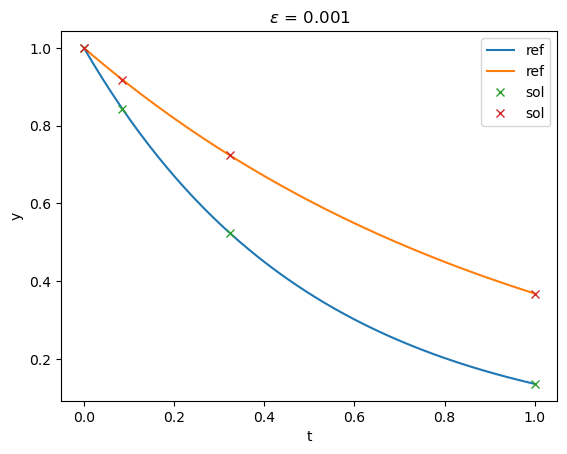

In [22]:
from extensisq import KC3I

def fun2(t, y, eps):
    return np.array([-(1 + 2*eps)*y[0] + y[1]**2,
            y[0] - y[1] - y[1]**2])

def jac2(t, y, eps):
    return np.array([[-(1 + 2*eps), 2*y[1]],
                    [1, -1 - 2*y[1]]])

def ref2(t):
    return np.stack([np.exp(-t)**2, np.exp(-t)])

t_span2 = (0, 1.)
y02 = [1., 1.]

eps = 1e-3

sol2 = solve_ivp(fun2, t_span2, y02, jac=jac2, args=(eps,), method=KC3I,
                 M=np.array([[eps, 0], [0, 1]]))
print(sol.message)

t = np.linspace(*t_span2)
plt.plot(t, ref2(t).T, label='ref')
plt.plot(sol2.t, sol2.y.T, 'x', label='sol')
plt.legend()
plt.title(f'$\epsilon$ = {eps}')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

The solution is close to the reference for $\epsilon = 10^{-3}$. What happens if $\epsilon = 0$?

The solver successfully reached the end of the integration interval.


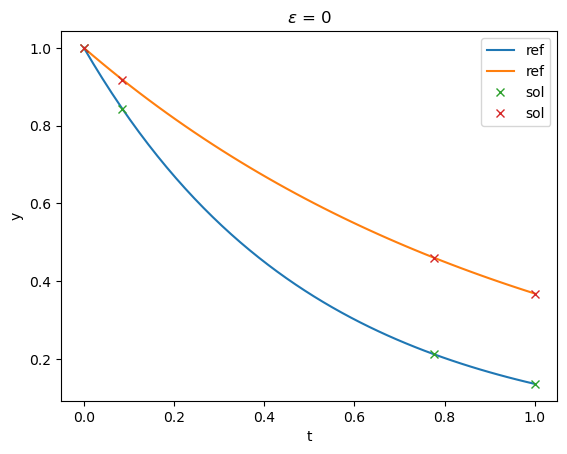

In [23]:
eps = 0

sol2e0 = solve_ivp(fun2, t_span2, y02, jac=jac2, args=(eps,), method=KC3I,
                   M=np.array([[eps, 0], [0, 1]]))
print(sol.message)

t = np.linspace(*t_span2)
plt.plot(t, ref2(t).T, label='ref')
plt.plot(sol2e0.t, sol2e0.y.T, 'x', label='sol')
plt.legend()
plt.title(f'$\epsilon$ = {eps}')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

Again, the solution is close to the reference. The second step of the solver is even larger. Notice that the mass matrix is singular now. The problem transformed into an DAE and the upper equation $0=-y_1 + y_2^2$ is the algebraic constraint.

The singular mass matrix also implies that the problem cannot be solved anymore in the standard from without this matrix. The reason that the solver can still handle this problem is that the matrix of the stage equations is $(M - h a_{ii} J)$ which is non-singular ($h$ is step size and $a_{ii}$ is the RK coefficient).

